In [1]:
import numpy as np
from math import e
import math
import random
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import copy
import cvxopt as cvo
import copy
from cvxopt import matrix, solvers

In [2]:
class Line():
    def create_line(self):
        x1,x2 = np.random.uniform(-1,1,2)
        y1,y2 = np.random.uniform(-1,1,2)
        self.slope = (y1-y2)/(x1-x2)
        self.b = y1-self.slope*x1
        
    def calculate(self,x):
        return self.slope*x+self.b
    
    def find_actual_y(self,X):
        return [np.sign(y - self.calculate(x)) for x,y in X] #higher than line = 1


class SVM:
    def __init__(self,soft_margin=False,C=.01):
        self.C = C
        self.soft_margin = soft_margin
        self.hard_margin = not self.soft_margin
    def getConstraints(self):
        if self.soft_margin:
            print("Soft Margin")
            #-alpha <= 0
            G1 = np.multiply(-1, np.eye(self.N))
            h1 = np.zeros(self.N)
            #alpha <= C
            G2 = np.eye(self.N)
            h2 = np.multiply(np.ones(self.N), self.C)
            
            G = cvo.matrix(np.vstack((G1, G2)))
            h = cvo.matrix(np.hstack((h1, h2)))
            
        if self.hard_margin:
            print("Hard Margin")
            #-alpha <= 0
            G = cvo.matrix(np.multiply(-1, np.eye(self.N)))
            h = cvo.matrix(np.zeros(self.N))
        return G, h
    def minimize(self):
        cvo.solvers.options['show_progress'] = False
        q = cvo.matrix(np.multiply(-1, np.ones((self.N,1))))
        P = cvo.matrix(np.multiply(np.outer(self.y, self.y), np.matmul(self.X,self.X.T)))
        A = cvo.matrix(self.y.reshape(1, -1), tc='d')
        b = cvo.matrix(0.0)
        G,h = self.getConstraints()
        cvo_sol = cvo.solvers.qp(P,q,G,h,A,b)
        self.alphas = np.ravel(cvo_sol['x'])
        
        
    def get_svms(self):
        return [idx for idx,an in enumerate(self.alphas) if an > 10**-5]
   
    def find_b(self):
        idx = np.argmax(self.alphas)
        xn = self.X[idx]
        yn = self.y[idx]
        return (1-yn*np.matmul(self.weights.T,xn))/yn
    
    def runSVM(self):
        self.minimize()
        self.weights = np.matmul(np.multiply(self.alphas,self.y),self.X)
        self.svms = self.get_svms()
        
        self.weights = np.array([self.find_b()] + list(self.weights))

In [3]:


class Plot():
    def plot_line(self,x,w):
        w0 = w[0]
        w1 = w[1]
        w2 = w[2]
        return (-w0-(x*w1))/w2
    def plot(self):
        df = pd.DataFrame(np.concatenate([np.array(self.X),np.array(self.y).reshape(-1,1)],axis=1), columns = ["x1","x2","y"])
        plt.scatter(df[df["y"]==-1].x1,df[df["y"]==-1].x2, color="r")
        plt.scatter(df[df["y"]==1].x1,df[df["y"]==1].x2, color="g")

        plt.plot([-1,1],[self.slope*x +self.b for x in [-1,1]], label="real split")
        plt.plot([-1,1],[self.plot_line(x,self.weights) for x in [-1,1]], label="SVM split")
       
        plt.legend()
        plt.xlim([-1, 1])
        plt.ylim([-1, 1])
        plt.show()
        
class create_test(SVM, Line,Plot):
    def __init__(self,N,soft_margin=True,C=5):
        super().__init__(soft_margin,C)
        self.create_line()

        self.N = N
        self.X = np.random.uniform(-1.0,1.0,(self.N,2))
        self.y = np.array(self.find_actual_y(self.X))
        
        self.runSVM()
        
        self.EoutSVM = self.Eout_error()
 
        self.numSVMs = len(self.svms)
        self.plot()
        self.Print()
        
    def Print(self):

        
        print("SVM Ein Error %s" % self.Ein_error())
        print("SVM Eout Error %s" % self.EoutSVM)
        
    def add_thresholdCol(self,X):
        return np.concatenate([[[1]for x in range(len(X))],X],axis=1)  
        
    def calculate_preds(self,X):
        w = self.weights
        X = self.add_thresholdCol(X)
        return np.sign(np.matmul(X, w.T))
        
    def Ein_error(self):
        w = self.weights
        preds = self.calculate_preds(self.X)
        return np.count_nonzero(preds!=self.y)/self.N
    
    def Eout_error(self):
        w = self.weights
        X = np.random.uniform(-1.0,1.0,(1000,2))
        y = self.find_actual_y(X)
        preds = self.calculate_preds(X)
        return np.count_nonzero(preds!=y)/1000

Hard Margin


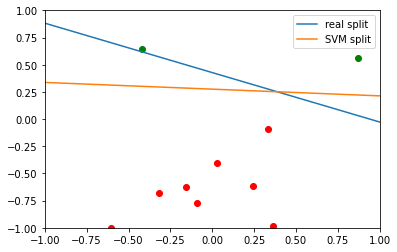

SVM Ein Error 0.0
SVM Eout Error 0.112


In [5]:
create_test(10,False)

Soft Margin


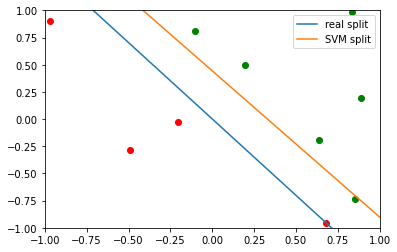

SVM Ein Error 0.1
SVM Eout Error 0.165


In [8]:
create_test(10,soft_margin=True)

Soft Margin


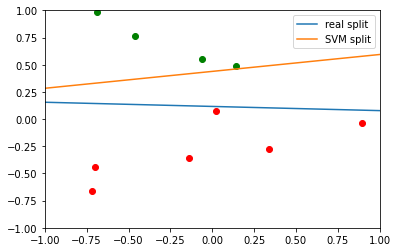

SVM Ein Error 0.0
SVM Eout Error 0.162


In [12]:
create_test(10,soft_margin=True)